import packages and libraries

In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
import os
import pickle

feed the dataset and shuffle it.

In [2]:
from sklearn.utils import shuffle

file_path = '../Sup/datset_fin.csv'
dataset = pd.read_csv(file_path,header=None)
dataset = shuffle(dataset)
dataset.head()

length = dataset.shape[0]
split_level = int(length*0.9)

brief inspection of the dataset

In [3]:
data = dataset[0]
data.head()

653     the movie itself is just as fine as its celebr...
432                   Adam Sandler does shitty comedy tho
1271                           Lopez is an awful actress 
1698                     incredibly graphic battle scenes
592     i have just witnessed a masterpiece of an acting!
Name: 0, dtype: object

In [4]:
label_pol = dataset[2]
label_pol.unique()

array(['Positive', 'Negative'], dtype=object)

start the nlp pipeline

In [5]:


import spacy
nlp = spacy.load('en_core_web_sm')

preprocess the dataset.

In [6]:
sentiment_terms = []
for review in nlp.pipe(data):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')
dataset[4] = sentiment_terms
#dataset.head(10)

define the model

In [7]:
model = Sequential()
model.add(Dense(512, input_shape=(6000,), activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

label encode the features

In [8]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(dataset[4]))

# seperete train and test set 900<- train set, 100<- test set
aspect_tokeniz = aspect_tokenized.iloc[:split_level,:]
test_x = aspect_tokenized.iloc[split_level:,:]

Using TensorFlow backend.


In [9]:
lbl_encoder = LabelEncoder()
dataset[5] = label_pol.apply(lambda x:1 if x == 'Positive' else 0)

dataset.head(15)

,0,1,2,4,5
653,the movie itself is just as fine as its celebr...,CAST#PERFORMANCE,Positive,fine celebrated,1
432,Adam Sandler does shitty comedy tho,CAST#PERFORMANCE,Negative,shitty,0
1271,Lopez is an awful actress,CAST#PERFORMANCE,Negative,awful,0
1698,incredibly graphic battle scenes,DIRECTING#PERFORMANCE,Positive,graphic,1
592,i have just witnessed a masterpiece of an acting!,CAST#PERFORMANCE,Positive,witness,1
1595,carefully organized film-maker,DIRECTING#PERFORMANCE,Positive,organize,1
1447,"expected a stronger performance from her, and ...",CAST#PERFORMANCE,Negative,expect strong convince,0
1840,an opportunity to connect emotionally with the...,CAST#PERFORMANCE,Positive,connect face,1
746,one actor that had a better performance,CAST#PERFORMANCE,Positive,well,1
1538,great filmmakers,DIRECTING#PERFORMANCE,Positive,great,1


split the dataset between train and test

In [10]:
import numpy as np
y = np.array(dataset[5])
train_y = y[:split_level]
test_y = y[split_level:]

define visualization function

In [11]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

train the model

0 2001
47 1987
Train on 1801 samples, validate on 1754 samples
Epoch 1/5
1801/1801 [==============================] - 1s 579us/sample - loss: 0.5859 - accuracy: 0.6807 - val_loss: 0.3601 - val_accuracy: 0.8620
Epoch 2/5
1801/1801 [==============================] - 0s 223us/sample - loss: 0.3509 - accuracy: 0.8384 - val_loss: 0.2564 - val_accuracy: 0.8729

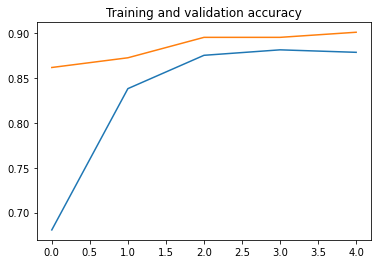

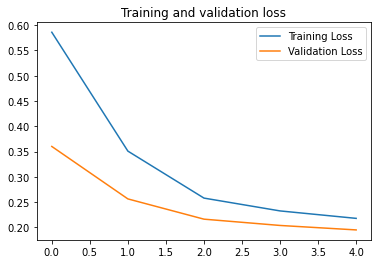

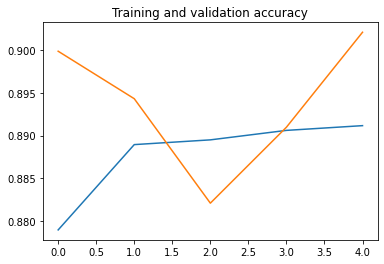

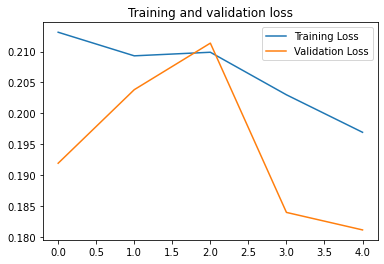

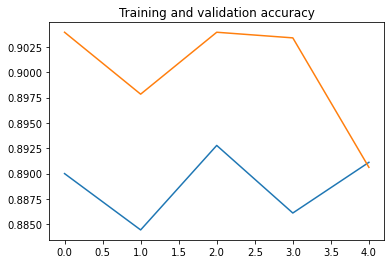

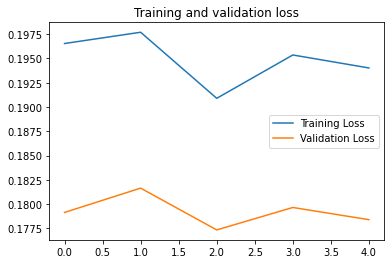

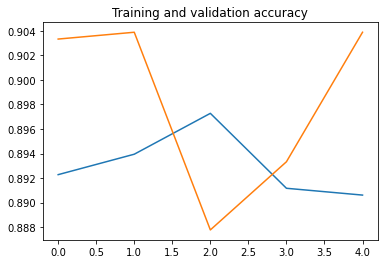

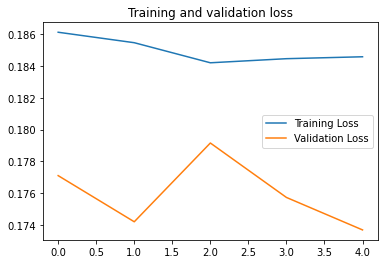

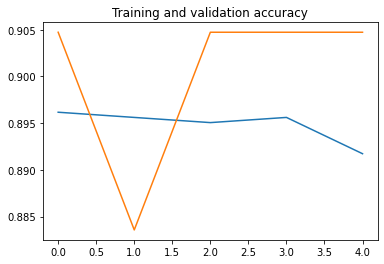

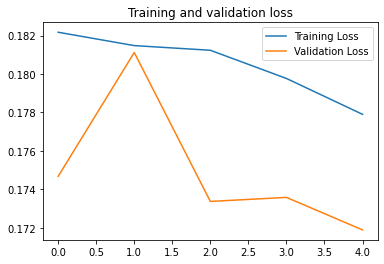

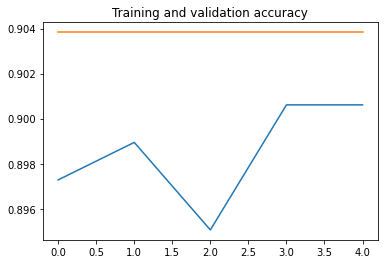

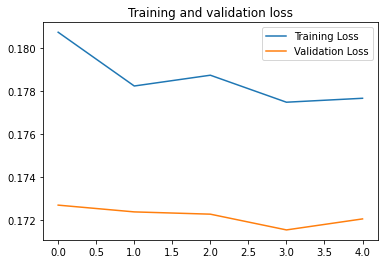

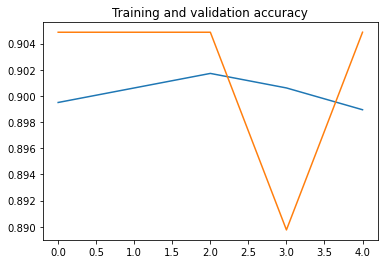

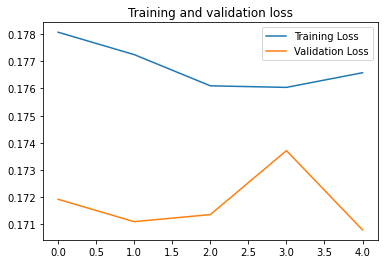

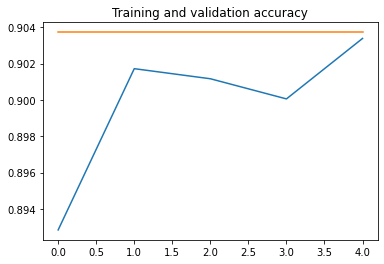

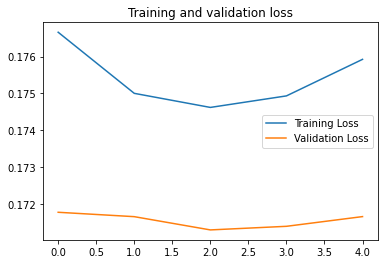

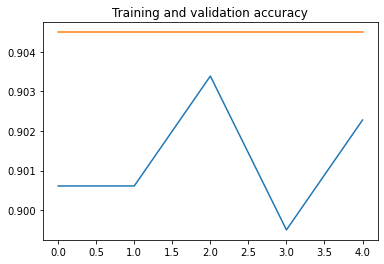

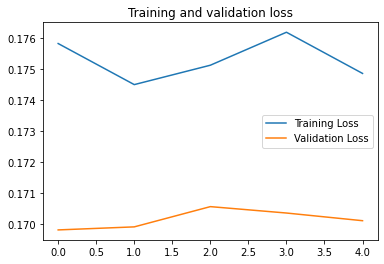

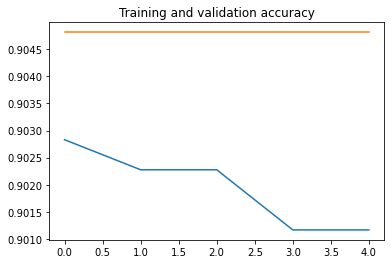

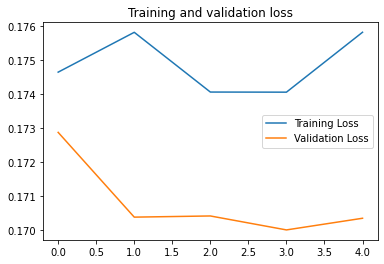

In [12]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokeniz.loc[train_start:train_end,:],\
                                       aspect_tokeniz.loc[test_start:test_end,:], \
                                       train_y[train_start:train_end], \
                                       train_y[test_start:test_end]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [16]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/sentimental_model.1.h5')
model.save_weights( "../Sup/sentimental_model_weights.1.h5")

In [14]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/sentimental_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
#with open('../Sup/sentimental_labeleEncorder.pkl', 'wb') as handle:
#   pickle.dump(lbl_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

evaluate on test set

In [15]:
from keras import metrics
logs = model.evaluate(test_x,test_y)
print(logs)
#predictions = model.predict(test_x)

#acc = metrics.confusion_matrix(y_test,predictions)
#print(acc)

201/201 [==============================] - 0s 149us/sample - loss: 0.8766 - accuracy: 0.7910
[0.8765715752074967, 0.7910448]
